<a href="https://www.kaggle.com/code/analystoleksandra/rfm-analysis-and-k-means-clustering-comparison?scriptVersionId=166463952" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
RFM (Recency, Frequency, Monetary) analysis is a well-established technique designed for behaviour-driven customer segmentation. Specifically, RFM analysis evaluates customers' recency (how long ago they made a purchase), frequency (how often they make purchases), and monetary value (how much money they spend).

RFM helps divide customers into various segments to identify those more likely to respond to promotions.

In this notebook, I will perform RFM segmentation and compare the results with those obtained using the K-means clustering algorithm on the same data.

Note: I will refer to the customer groups obtained by the RFM framework as 'segments' and those obtained with the K-means clustering algorithm as 'clusters'.

# Table of Contents
- Data Import
- Data Exploration and Cleaning
    - Checking null values
    - Duplicate values
    - Cleaning records with zero UnitPrice
    - Removing cancelled purchases
- RFM Analysis
    - RFM Framework
    - Calculating Recency, Frequency and Monetary Values
    - Exploratory Analysis of RFM Features
        - Distributions
        - Correlations
        - Box Plots
    - Assigning RFM Scores
    - RFM Segmentation
    - Analysis of Segments
- K-Means Clustering
    - Log Transformation
    - Standardising Data
    - Elbow Method
    - Silhouette Score
    - Model with 4 Clusters
    - Evaluating Clusters
        - Recency and Frequency by Cluster
        - Recency and Monetary by Cluster
- Comparing Results: RFM Segments vs. K-Mean Clusters
    - Descriptive Statistics
    - Mapping of Clusters and RFM Segments
- Conclusion
    - Example of marketing strategies for RFM segments
- References

# Data Import
This dataset contains 8 variables that correspond to:

<b> InvoiceNo </b>: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  
<b> StockCode </b> : Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
<b> Description </b>: Product (item) name. Nominal.  
<b> Quantity </b>: The quantities of each product (item) per transaction. Numeric.  
<b> InvoiceDate </b>: Invoice date and time.  
<b> UnitPrice </b>: Unit price. Numeric, Product price per unit in sterling.  
<b> CustomerID </b>: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
<b> Country </b>: Country name. Nominal, the name of the country where each customer resides.

In [1]:
#Importing necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', 
                   encoding = 'unicode_escape',
                   parse_dates = ['InvoiceDate'],
                   dtype={'CustomerID': str,'InvoiceNo': str})
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


# Data Exploration and Cleaning
## Checking Null Values

In [4]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are about 135K records without a CustomerID. Our goal is to segment the customers. So, CustomerID is crucial for segmentation. Let's drop the rows where CustomerID is null.

In [5]:
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Looks like the null Descriptions are gone with null CustomerIDs. 

## Duplicate Values

In [6]:
print('Number of duplicates: {}'.format(data.duplicated().sum()))


Number of duplicates: 5225


In [7]:
data.drop_duplicates(inplace = True)

The data has no duplicate values now.

## Cleaning Records with Zero UnitPrice

There are 40 records that have UnitPrice equal 0. I did not notice any pattern in the records with UnitPrice==0. There were no field indicating discount or promotion.  These records may result to Monetary value equal zero. These records will be removed from the dataset.

In [8]:
data[data['UnitPrice']==0].describe()

,Quantity,InvoiceDate,UnitPrice
count,40.000000,40,40.0
mean,347.100000,2011-07-26 08:19:34.500000,0.0
min,1.000000,2010-12-05 14:02:00,0.0
25%,1.000000,2011-04-12 05:53:15,0.0
50%,4.500000,2011-08-26 14:19:00,0.0
75%,24.000000,2011-11-05 06:16:45,0.0
max,12540.000000,2011-11-25 15:57:00,0.0
std,1978.311813,NaN,0.0


In [9]:
data=data[data['UnitPrice']!=0]

The records where UnitPrice equals 0 were removed.

## Removing Cancelled Purchases
If the InvoiceNo starts from a letter 'C' that means that the purchase was cancelled. The values of such purchases should not be included in the monetary value when RFM analysis is performed. There are 8,905 records where InvoiceNo starts from 'C'.

In [10]:
len(data[data['InvoiceNo'].str.startswith('C')])


8872

In [11]:
data = data[~data['InvoiceNo'].str.startswith('C')]


Now the data does not contain cancelled purchases.

# RFM Analysis

## RFM Framework

There are multiple approaches for RFM segmentation. 
I will use the RFM framework with assignment of scores from 1 to 3 for each (Recency, Frequency, Monetary). Based on the assigned score the below customer segments are defined:

| Segment name | RFM score breakouts | Description |
|------------|--------------------------------------|-------------|
| Champions  | 333, 332, 323                       | The best customers  |
| Loyal      | 321, 322, 331, 232, 233               | Valuable customers that are engaged |
| Recent     | 312, 313, 311, 222, 223               | Recent customers  |
| Needs attention | 213, 221, 123, 132, 133          | A valuable customer that has not purchased recently |
| At risk    | 231, 212, 122, 131, 211               | A customer that has not purchased recently and/or tends to spend less overall |
| Inactive   | 111, 112, 113, 121                   | A lapsed customer  |

## Calculating Recency, Frequency and Monetary Values

<b> Recency </b> is the number of days since the last purchase made by a customer. To calculate Recency, we need calculated how many days passed from the current date to the date of the last purchase. Thus, we need to define the current date. The data contains purchases from 2010 and 2011. The maximum data available in the dataset is 2011-12-09. Let's assume the analysis is performed 2 days after the last purchase. We take 2 days to avoid zeros in Recency.  

In [12]:
print(data['InvoiceDate'].max())
current_date = dt.datetime(2011,12,11)

2011-12-09 12:50:00


<b> Frequency </b> shows how often a customer purchases from the company within the report’s time frame. To calculate Frequency, we will calculate number of unique invoices for each CustomerID.

<b> Monetary </b> is the total cost spend on purchases by every customer. Before calculating the Monetary, we need to calculate total cost by multiplying number of UtitPrice and Quantity.

In [13]:
data['TotalCost'] = data['Quantity'] * data['UnitPrice']

In [14]:
rfm = data.groupby("CustomerID").agg({"InvoiceDate" : lambda InvoiceDate :(current_date - InvoiceDate.max()).days,  # Recency
                                     "InvoiceNo" : lambda InvoiceNo: InvoiceNo.nunique(),  # Frequency
                                     "TotalCost":  lambda TotalCost: TotalCost.sum()})    # Monetary
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


## Exploratory Analysis of RFM Features


In [15]:
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,93.059474,4.272015,2048.688081
std,100.012264,7.697998,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.750000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


### Distributions

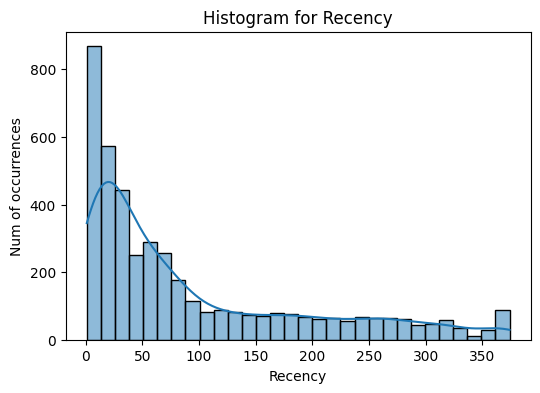

In [16]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm, x='Recency', bins=30, kde=True)
plt.title('Histogram for Recency')
plt.xlabel('Recency')
plt.ylabel('Num of occurrences')
plt.show()

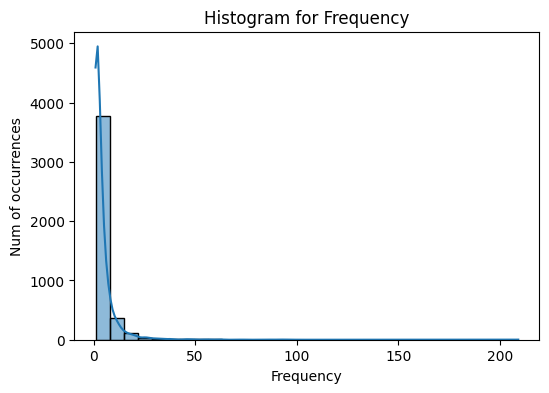

In [17]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm, x='Frequency', bins=30, kde=True)
plt.title('Histogram for Frequency')
plt.xlabel('Frequency')
plt.ylabel('Num of occurrences')
plt.show()

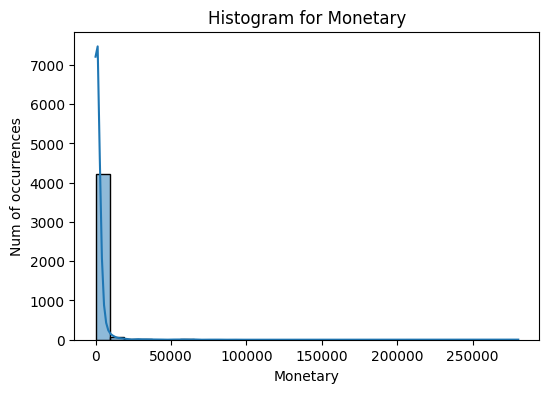

In [18]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm, x='Monetary', bins=30, kde=True)
plt.title('Histogram for Monetary')
plt.xlabel('Monetary')
plt.ylabel('Num of occurrences')
plt.show()

### Correlation

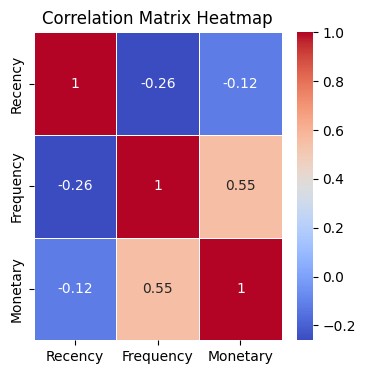

In [19]:
corr_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()
plt.figure(figsize=(4,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

There is a moderate correlation between Frequency and Monetary. This correlation is expected, as customers tend to spend more when they make purchases more frequently.

### Box Plots

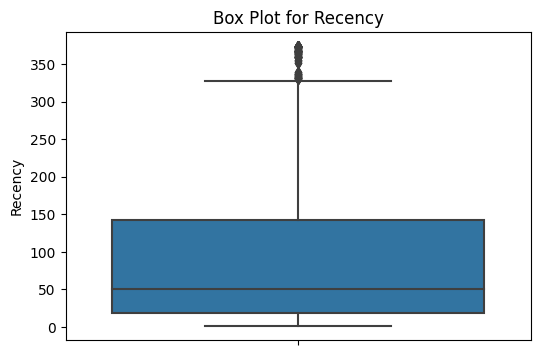

In [20]:
plt.figure(figsize=(6, 4))  
sns.boxplot(data = rfm, y='Recency')
plt.title('Box Plot for Recency')
plt.ylabel('Recency')
plt.show()

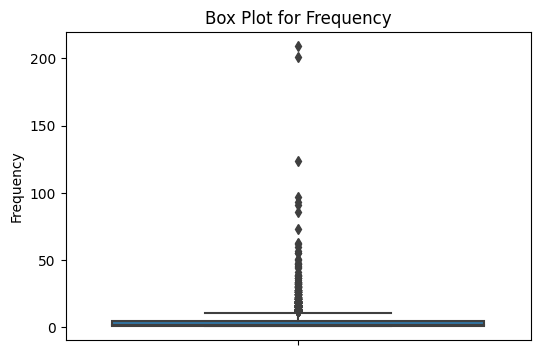

In [21]:
plt.figure(figsize=(6, 4))  
sns.boxplot(data = rfm, y='Frequency')
plt.title('Box Plot for Frequency')
plt.ylabel('Frequency')
plt.show()

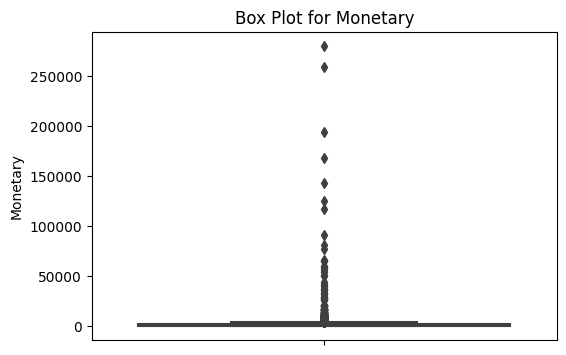

In [22]:
plt.figure(figsize=(6, 4))  
sns.boxplot(data = rfm, y='Monetary')
plt.title('Box Plot for Monetary')
plt.ylabel('Monetary')
plt.show()

Recency, Frequency, and Monetary features have a lot of outliers. The outliers may make segmentation process more difficult.

## Assigning RFM Scores

There are multiple approaches for RFM segmentation. 
I will use the RFM framework with assignment of scores from 1 to 3 for each (Recency, Frequency, Monetary). 3 is the best/highest value, and 1 is the lowest/worst value. 

A final RFM score is calculated simply by combining individual RFM score numbers.  
The RFM segments will be defined using the below table   

| Segment name | RFM score breakouts | Description |
|------------|--------------------------------------|-------------|
| Champions  | 333, 332, 323                       | The best customers  |
| Loyal      | 321, 322, 331, 232, 233               | Valuable customers that are engaged |
| Recent     | 312, 313, 311, 222, 223               | Recent customers  |
| Needs attention | 213, 221, 123, 132, 133          | A valuable customer that has not purchased recently |
| At risk    | 231, 212, 122, 131, 211               | A customer that has not purchased recently and/or tends to spend less overall |
| Inactive   | 111, 112, 113, 121                   | A lapsed customer  |

In [23]:
rfm["Recency_Score"]  = pd.qcut(rfm['Recency'], 3, [3, 2, 1])
rfm["Frequency_Score"]  = pd.qcut(rfm['Frequency'].rank(method="first"), 3, [1, 2, 3])
rfm["Monetary_Score"]  = pd.qcut(rfm['Monetary'], 3, [1, 2, 3])
rfm["RFM_Score"] = rfm["Recency_Score"].astype(str) + rfm["Frequency_Score"].astype(str) + rfm["Monetary_Score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,3,113
12347,3,7,4310.00,3,3,3,333
12348,76,4,1797.24,2,2,3,223
12349,19,1,1757.55,3,1,3,313
12350,311,1,334.40,1,1,1,111


## RFM Segmentation


In [24]:
def segment_customers(rfm_score):
    if rfm_score in ['333', '332', '323']:
        return 'Champions'
    elif rfm_score in ['321', '322', '331', '232', '233']:
        return 'Loyal'
    elif rfm_score in ['312', '313', '311', '222', '223']:
        return 'Recent'
    elif rfm_score in ['213', '221', '123', '132', '133']:
        return 'Needs attention'
    elif rfm_score in ['231', '212', '122', '131', '211']:
        return 'At risk'
    elif rfm_score in ['111', '112', '113', '121']:
        return 'Inactive'
    
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customers)
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Recency          4338 non-null   int64   
 1   Frequency        4338 non-null   int64   
 2   Monetary         4338 non-null   float64 
 3   Recency_Score    4338 non-null   category
 4   Frequency_Score  4338 non-null   category
 5   Monetary_Score   4338 non-null   category
 6   RFM_Score        4338 non-null   object  
 7   Segment          4338 non-null   object  
dtypes: category(3), float64(1), int64(2), object(2)
memory usage: 345.5+ KB


In [25]:
rfm.reset_index(inplace=True)
rfm.groupby('Segment').agg({'CustomerID':'count'})

,CustomerID
Segment,
At risk,703
Champions,960
Inactive,974
Loyal,778
Needs attention,334
Recent,589


## Analysis of Segments

### Statistical characteristics of the segments

In [26]:
rfm_stats = rfm[['Recency','Frequency','Monetary','Segment']].groupby('Segment').agg({'mean','std','max','min'})
format_rules = {
    ('Recency', 'mean'): '{:.2f}',
    ('Recency', 'std'): '{:.2f}',
    ('Recency', 'max'): '{:.0f}',
    ('Recency', 'min'): '{:.0f}',
    ('Monetary', 'mean'): '£{:,.2f}',
    ('Monetary', 'std'): '£{:,.2f}',
    ('Monetary', 'max'): '£{:,.0f}',
    ('Monetary', 'min'): '£{:,.0f}',
    ('Frequency', 'mean'): '{:.2f}',
    ('Frequency', 'std'): '{:.2f}',
    ('Frequency', 'max'): '{:.0f}',
    ('Frequency', 'min'): '{:.0f}',
}
table_styles = [
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'}
]

rfm_stats_style = rfm_stats.style.format(format_rules)
rfm_stats_style = rfm_stats_style.set_table_styles(table_styles)
rfm_stats_style = rfm_stats_style.set_table_styles(
    {('Monetary', 'std'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                            {'selector': 'td', 'props': 'border-left: 1px solid black'}
                          ],
    ('Frequency', 'std'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                            {'selector': 'td', 'props': 'border-left: 1px solid black'}
                          ]
    }, 
    overwrite = False, 
    axis=0)
rfm_stats_style


### Number of Customers per Segment

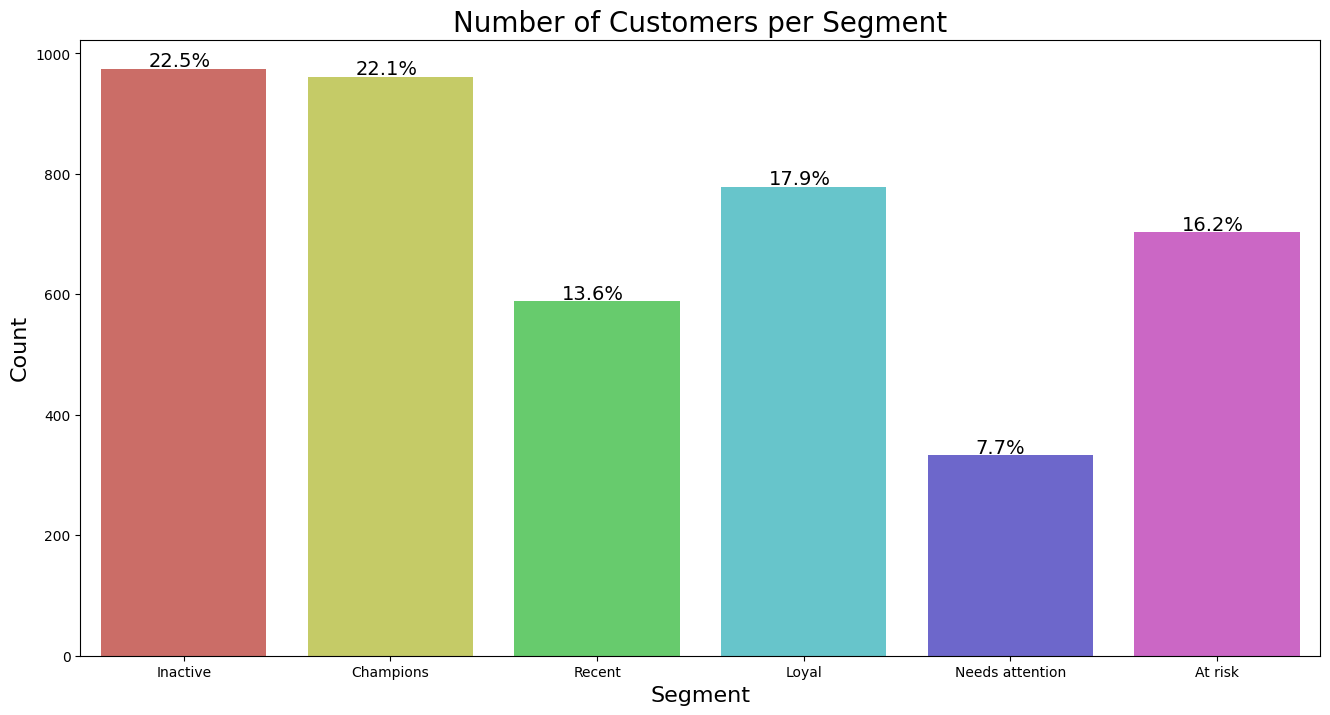

In [27]:
plt.figure(figsize = (16, 8))
ax = sns.countplot(data = rfm,
                   x = 'Segment',
                   palette = 'hls')
total = len(rfm.Segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers per Segment', size = 20)
plt.xlabel('Segment', size = 16)
plt.ylabel('Count', size = 16)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

### Recency and Frequency by Segment

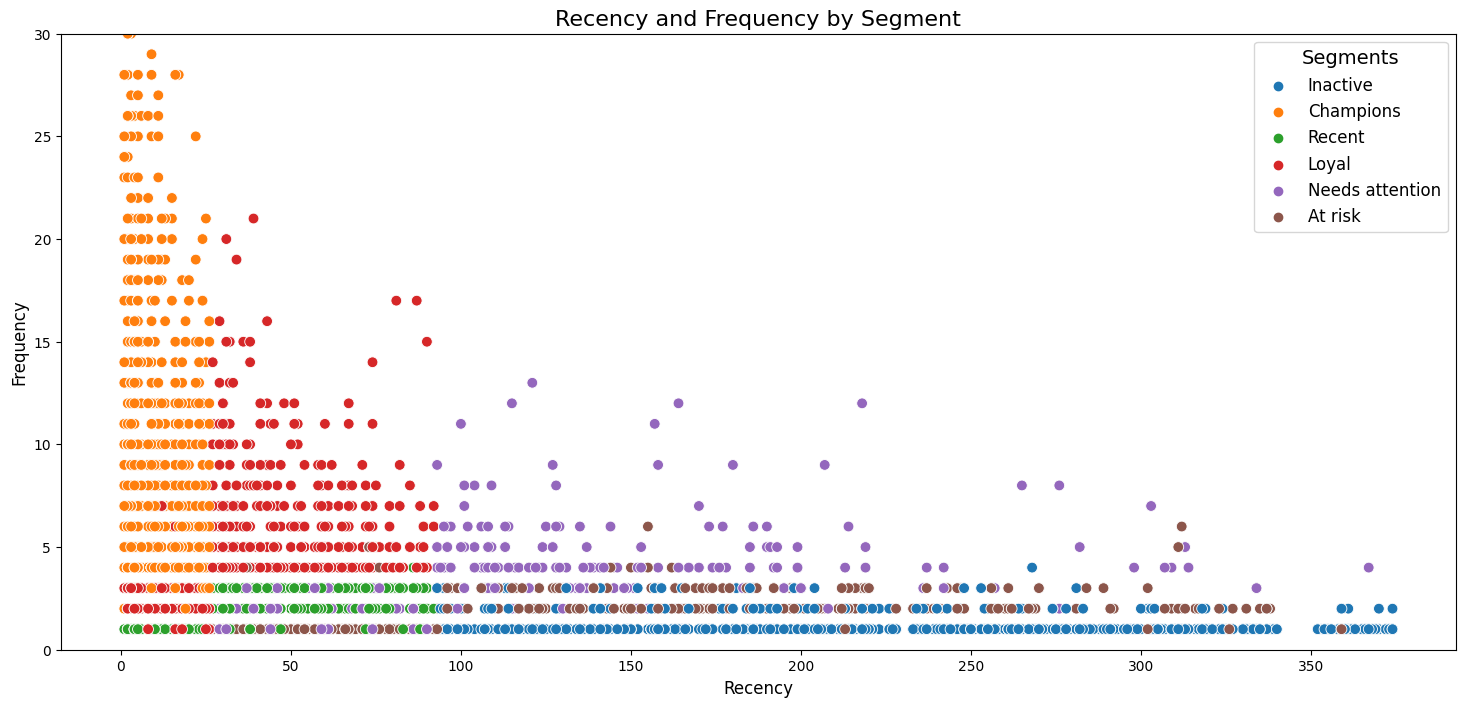

In [28]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency", hue="Segment", palette='tab10', s=60
)
plt.title("Recency and Frequency by Segment", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.ylim(0, 30)  #the axis needs limiting because of the high number of outliers
plt.show()

- Some 'At risk' and 'Inactive' customers are mixed together
- Some 'Recent', 'Needs attention' and 'At risk' customers are mixed together

### Recency and Monetary by Segment

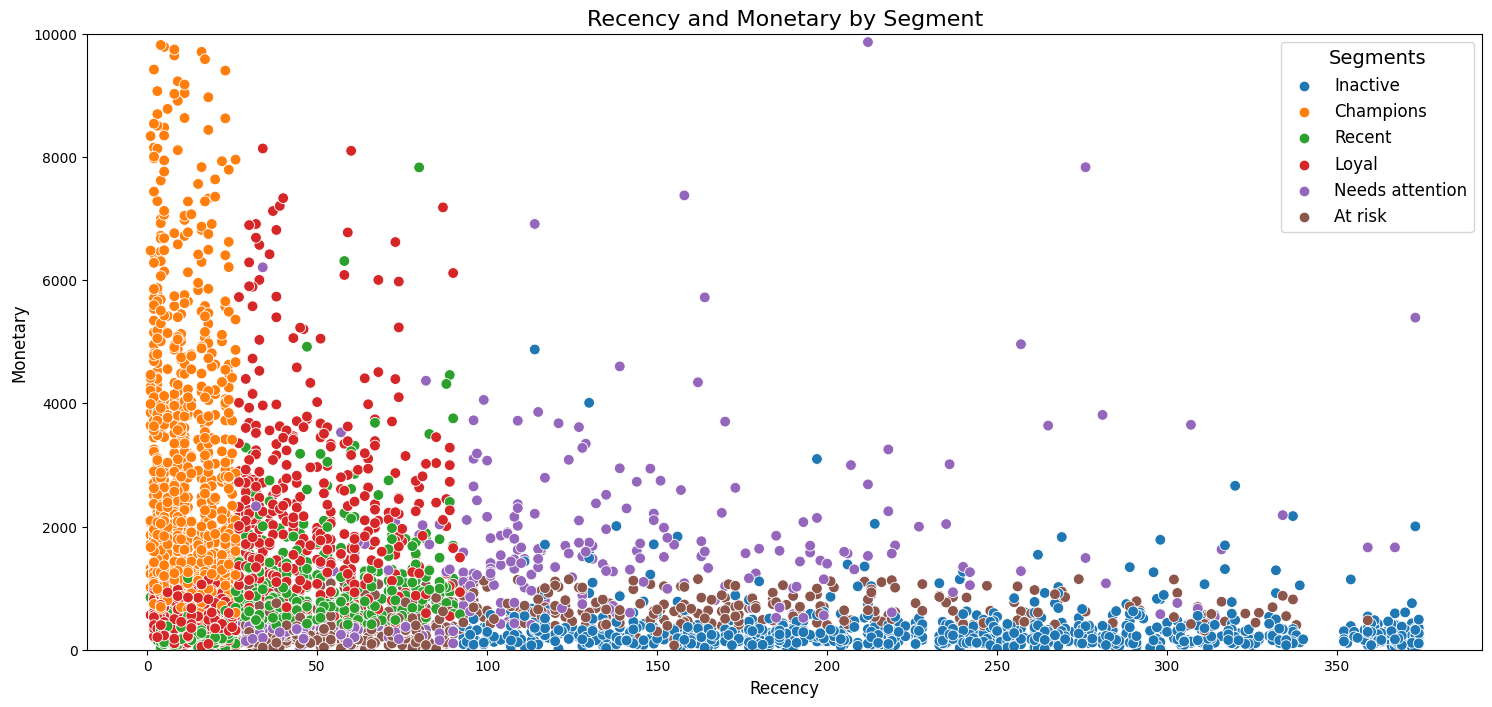

In [29]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Monetary", hue="Segment", palette='tab10', s=60
)
plt.title("Recency and Monetary by Segment", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Monetary", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.ylim(0, 10000) # the axis needs limiting because of the high number of outliers
plt.show()

- Some 'At risk' and 'Inactive' customers are mixed together
- Some 'Recent', 'Needs attention' and 'At risk' customers are mixed together
Similar observations were on the Recency and Frequency scatter plot.

### Box Plots for Segments

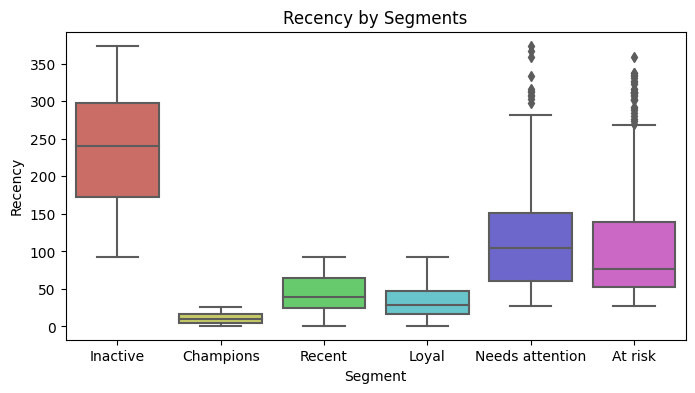

In [30]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Segment', y='Recency', data=rfm, palette='hls')
plt.title('Recency by Segments')
plt.xlabel('Segment')
plt.ylabel('Recency')
plt.show()

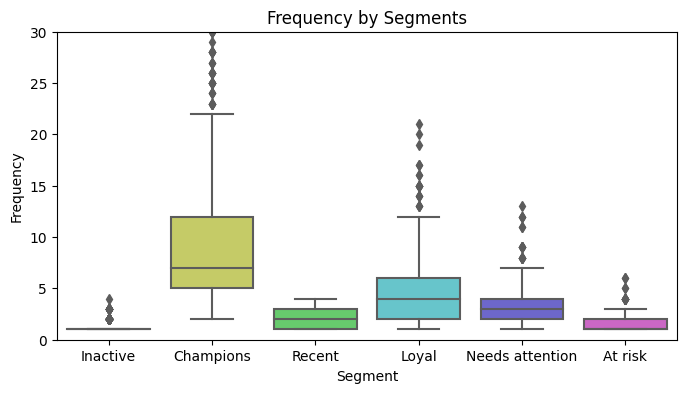

In [31]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Segment', y='Frequency', data=rfm, palette='hls')
plt.title('Frequency by Segments')
plt.xlabel('Segment')
plt.ylabel('Frequency')
plt.ylim(0, 30)  #the axis needs limiting because of the high number of outliers
plt.show()

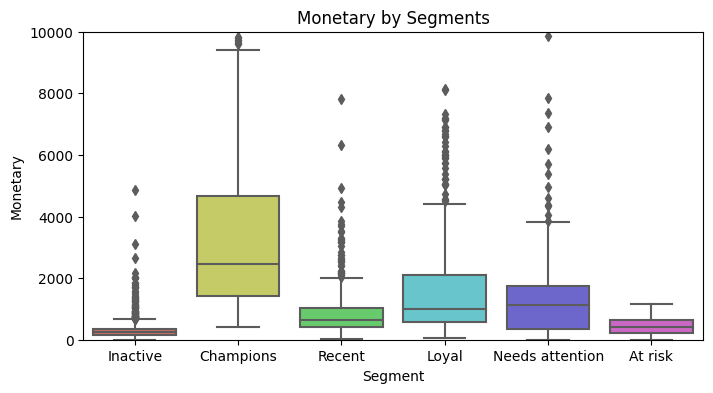

In [32]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Segment', y='Monetary', data=rfm, palette='hls')
plt.title('Monetary by Segments')
plt.xlabel('Segment')
plt.ylabel('Monetary')
plt.ylim(0, 10000) # the axis needs limiting because of the high number of outliers
plt.show()


# K-Means Clustering
K-Means clustering is a very common unsupervised learning algorithm. It scales to very large datasets and tends to work well in practice. The K-Means clustering algorithm tries to find the best way of grouping data points into k different groups, where k is a parameter given to the algorithm.  
In this section I will use elbow method and silhouette score to determine the optimal number of clusters for Recency, Frequency and Monetary.  

## Log Transformation
Recency, Frequency and Monetary values have right-skewed distributions. K-means clustering works well with symmetric distribution of variables.

In [33]:
cols_for_clustering = ['Recency', 'Frequency', 'Monetary']
rfm_log = rfm.copy()
rfm_log[cols_for_clustering] = rfm[cols_for_clustering].apply(np.log1p)
rfm_log.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,3.857192,1.345582,6.588562
std,1.307060,0.683104,1.258438
min,0.693147,0.693147,1.558145
25%,2.944439,0.693147,5.728418
50%,3.951244,1.098612,6.506636
75%,4.968071,1.791759,7.415535
max,5.926926,5.347108,12.543284


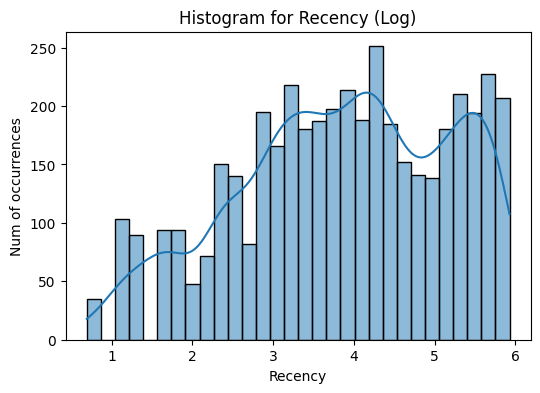

In [34]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm_log, x='Recency', bins=30, kde=True)
plt.title('Histogram for Recency (Log)')
plt.xlabel('Recency')
plt.ylabel('Num of occurrences')
plt.show()

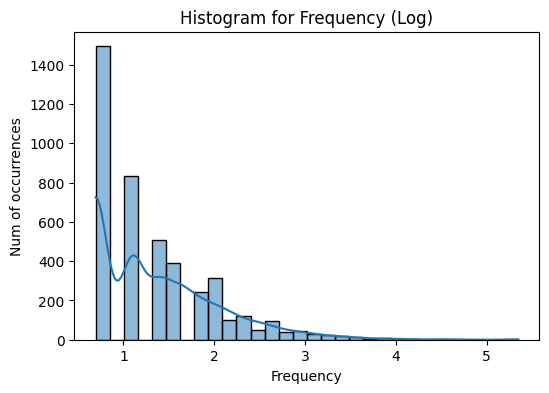

In [35]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm_log, x='Frequency', bins=30, kde=True)
plt.title('Histogram for Frequency (Log)')
plt.xlabel('Frequency')
plt.ylabel('Num of occurrences')
plt.show()

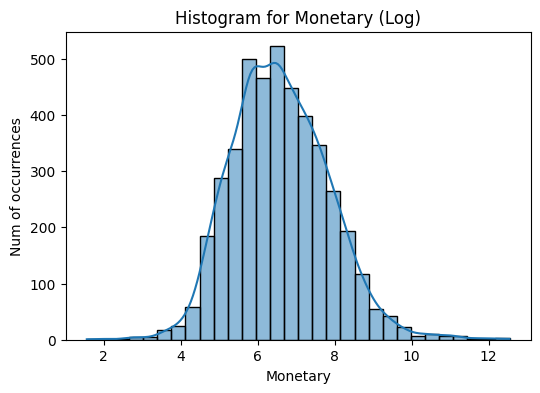

In [36]:
plt.figure(figsize=(6, 4))  
sns.histplot(data=rfm_log, x='Monetary', bins=30, kde=True)
plt.title('Histogram for Monetary (Log)')
plt.xlabel('Monetary')
plt.ylabel('Num of occurrences')
plt.show()

## Standardising Data
K-Means clustering relies on distances between data points to assign them to clusters. If features have different scales, the algorithm may give more weight to features with larger scales, leading to biased cluster assignments. RobustScaler scales the data based on the interquartile range (IQR) to handle outliers. Recency, Frequency and Monetary features have many outliers therefore RobustScaler may be a good choice.

In [37]:
scaler = RobustScaler()
rfm_scaled = rfm_log.copy()
rfm_scaled[cols_for_clustering] = scaler.fit_transform(rfm_log[cols_for_clustering])
rfm_scaled[cols_for_clustering].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4.338000e+03
mean,-0.046477,0.224802,4.856011e-02
std,0.645898,0.621788,7.459105e-01
min,-1.610024,-0.369070,-2.933106e+00
25%,-0.497524,-0.369070,-4.612708e-01
50%,0.000000,0.000000,-2.632240e-16
75%,0.502476,0.630930,5.387292e-01
max,0.976305,3.867147,3.578086e+00


## Elbow Method

The elbow method is a technique that helps to determine the optimal number of clusters (K) for K-means clustering algorithm.

In [38]:
X = rfm_scaled[cols_for_clustering]
inertia_list = []
for K in range(2,10):
    inertia = KMeans(n_clusters=K, random_state=7).fit(X).inertia_
    inertia_list.append(inertia)    

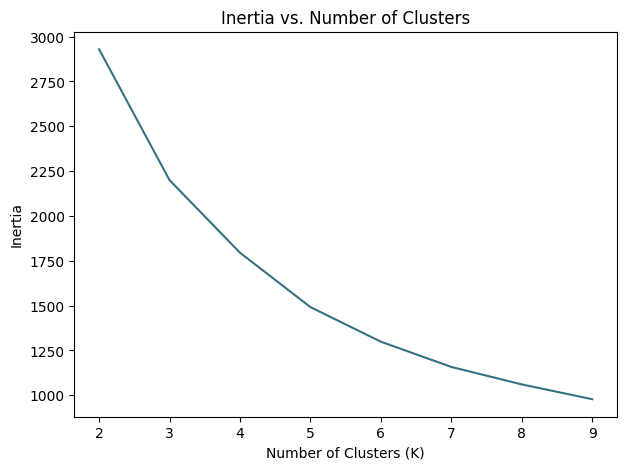

In [39]:
plt.figure(figsize=[7,5])
plt.plot(range(2,10), inertia_list, color=(54 / 255, 113 / 255, 130 / 255))
plt.title("Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

There is no clear elbow on the chart. 5 or 6 clusters may be a good number of clusters.

## Silhouette Score  
Silhouette score is a metric that used to assess the quality of clustering. A higher silhouette score indicates that the clusters are well-separated, while a lower score suggests that the clusters may overlap or are poorly defined.

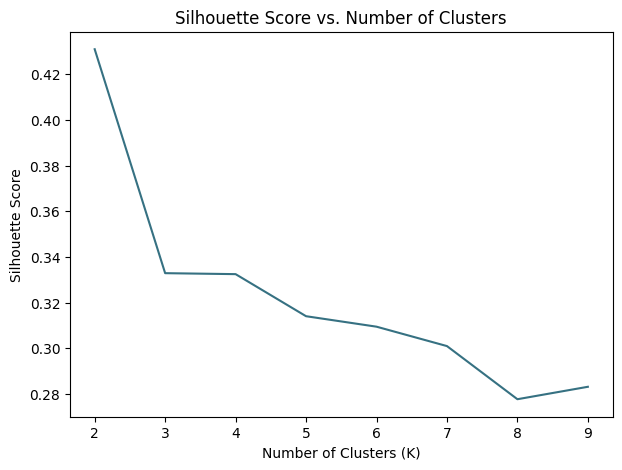

In [40]:
from sklearn.metrics import silhouette_score
silhouette_list = []
for K in range(2,10):
    model = KMeans(n_clusters = K, random_state=7)
    clusters = model.fit_predict(X)
    s_avg = silhouette_score(X, clusters)
    silhouette_list.append(s_avg)

plt.figure(figsize=[7,5])
plt.plot(range(2,10), silhouette_list, color=(54 / 255, 113 / 255, 130 / 255))
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

The highest Silhouette score is for 2 clusters. 4 clusters seem to be a good enough choice.

## Model with 4 Clusters

In [41]:
model = KMeans(n_clusters=4, random_state = 7)
model.fit(rfm_scaled[cols_for_clustering])
rfm_scaled['Cluster'] = model.predict(rfm_scaled[cols_for_clustering])
rfm['Cluster'] = rfm_scaled.Cluster

## Evaluating Clusters

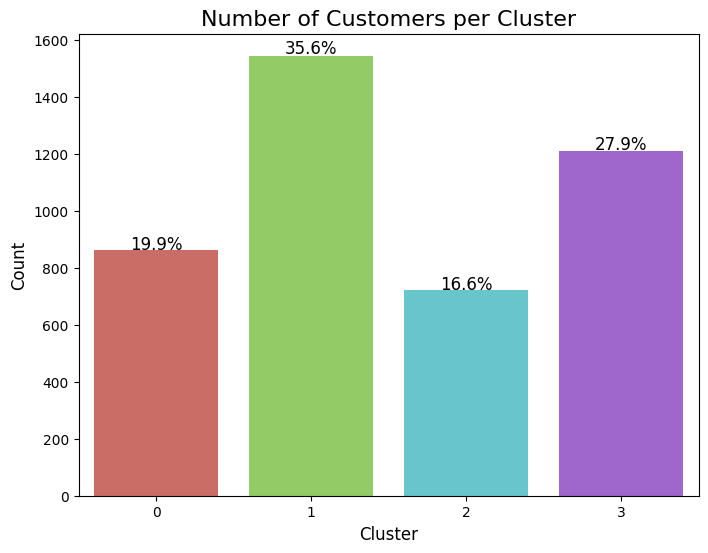

In [42]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(data = rfm,
                   x = 'Cluster',
                   palette = 'hls')
total = len(rfm.Cluster)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 12)
plt.title('Number of Customers per Cluster', size = 16)
plt.xlabel('Cluster', size = 12)
plt.ylabel('Count', size = 12)
plt.show()

### Recency and Frequency by Cluster

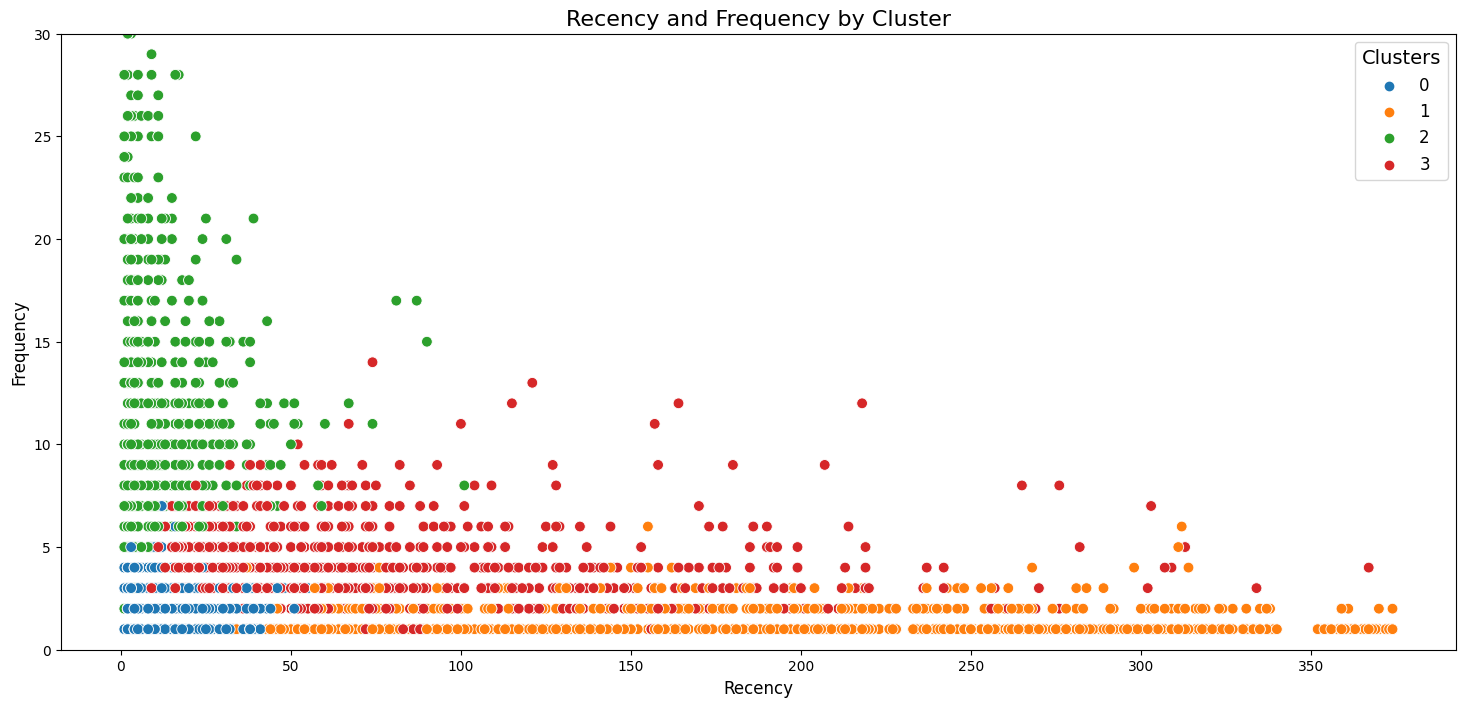

In [43]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Frequency", hue="Cluster", palette='tab10', s=60
)
plt.title("Recency and Frequency by Cluster", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.ylim(0, 30)  #the axis needs limiting because of the high number of outliers
plt.show()

### Recency and Monetary by Cluster

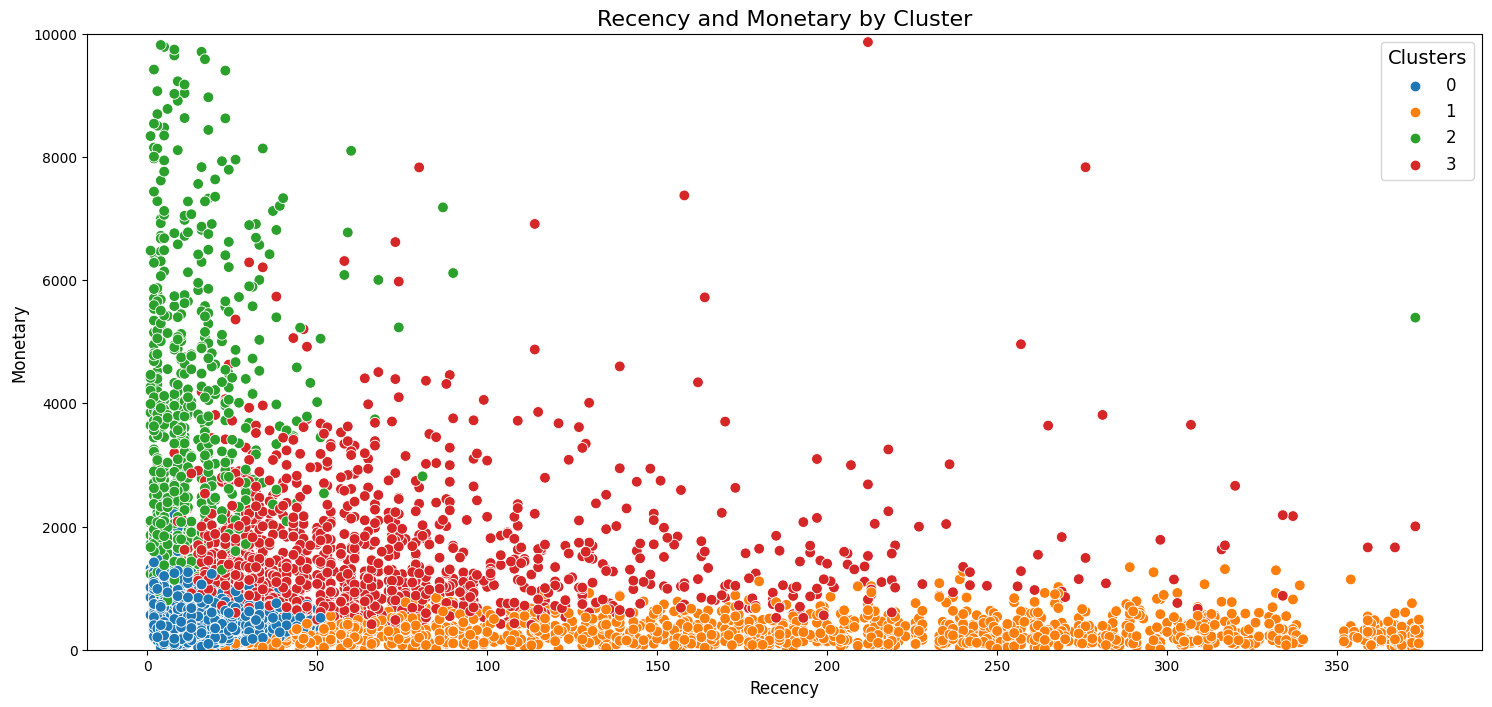

In [44]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="Recency", y="Monetary", hue="Cluster", palette='tab10', s=60
)
plt.title("Recency and Monetary by Cluster", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Monetary", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Clusters", title_fontsize=14)
plt.ylim(0, 10000) # the axis needs limiting because of the high number of outliers
plt.show()

# Comparing Results: RFM Segments vs. K-Mean Clusters
## Descriptive Statistics

In [45]:
rfm_stats_cl = rfm[['Recency','Frequency','Monetary','Cluster']].groupby('Cluster').agg({'mean','std','max','min'})
format_rules = {
    ('Recency', 'mean'): '{:.2f}',
    ('Recency', 'std'): '{:.2f}',
    ('Recency', 'max'): '{:.0f}',
    ('Recency', 'min'): '{:.0f}',
    ('Monetary', 'mean'): '£{:,.2f}',
    ('Monetary', 'std'): '£{:,.2f}',
    ('Monetary', 'max'): '£{:,.0f}',
    ('Monetary', 'min'): '£{:,.0f}',
    ('Frequency', 'mean'): '{:.2f}',
    ('Frequency', 'std'): '{:.2f}',
    ('Frequency', 'max'): '{:.0f}',
    ('Frequency', 'min'): '{:.0f}',
}
table_styles = [
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1.2em;'}
]

rfm_stats_cl_style = rfm_stats_cl.style.format(format_rules)
rfm_stats_cl_style = rfm_stats_cl_style.set_table_styles(table_styles)
rfm_stats_cl_style = rfm_stats_cl_style.set_table_styles(
    {('Monetary', 'std'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                            {'selector': 'td', 'props': 'border-left: 1px solid black'}
                          ],
    ('Frequency', 'std'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                            {'selector': 'td', 'props': 'border-left: 1px solid black'}
                          ]
    }, 
    overwrite = False, 
    axis=0)
rfm_stats_cl_style

In [46]:
combined_stats = pd.concat([rfm_stats_cl.assign(Source='Cluster'), rfm_stats.assign(Source='Segment')])
combined_stats.head(20)

Recency                              Frequency             \
                    min         std  max        mean       min        std   
0                     1   12.425631   58   18.969838         1   1.157310   
1                    19  101.779115  374  184.181877         1   0.604074   
2                     1   18.641575  373   13.279778         2  15.358359   
3                     8   61.294507  373   77.081059         1   1.861166   
At risk              27   73.130287  359  103.526316         1   0.816631   
Champions             1    7.439885   26   11.181250         2  13.920943   
Inactive             93   79.987216  374  236.309035         1   0.436095   
Loyal                 1   22.433228   92   33.061697         1   3.614359   
Needs attention      27   70.417304  373  116.874251         1   2.636652   
Recent                1   23.791914   92   42.879457         1   0.866304   

                                Monetary                           \
                 max       mean      min           std        max   
0                  7   2.235499    35.40    361.199288    3861.00   
1                  6   1.304854     3.75    199.536740    1340.32   
2                209  13.664820   801.12  20617.644264  280206.02   
3                 14   3.906534   373.65   2941.189570   77183.60   
At risk            6   1.547653     6.20    278.915871    1149.02   
Champions        209  10.706250   400.86  17978.933169  280206.02   
Inactive           4   1.163244     3.75   2487.674255   77183.60   
Loyal             63   4.703085    49.80   3433.932571   80850.84   
Needs attention   34   3.461078     6.90   3459.751153   44534.30   
Recent             4   2.067912    30.00   1014.815794   12601.83   

                               Source  
                        mean           
0                 558.443387  Cluster  
1                 308.705192  Cluster  
2                8086.198906  Cluster  
3                1729.235371  Cluster  
At risk           467.986132  Segment  
Champions        5998.648469  Segment  
Inactive          397.662012  Segment  
Loyal            1743.005040  Segment  
Needs attention  1599.673566  Segment  
Recent            885.976946  Segment

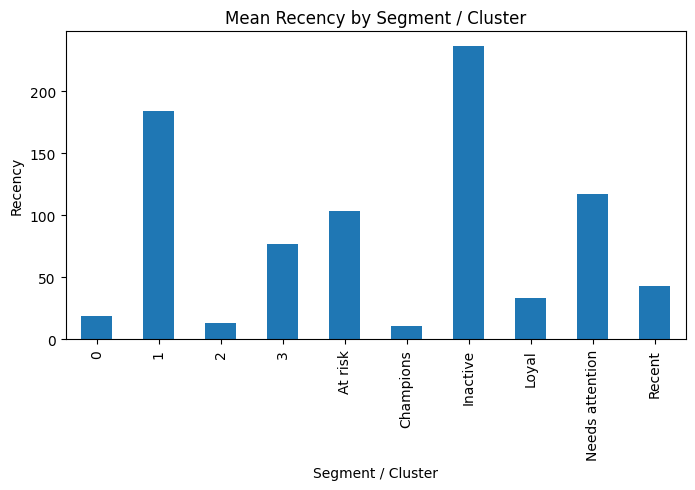

In [47]:
combined_stats[('Recency', 'mean')].plot(kind='bar', figsize=(8, 4))
plt.title('Mean Recency by Segment / Cluster')
plt.xlabel('Segment / Cluster')
plt.ylabel('Recency')
plt.show()

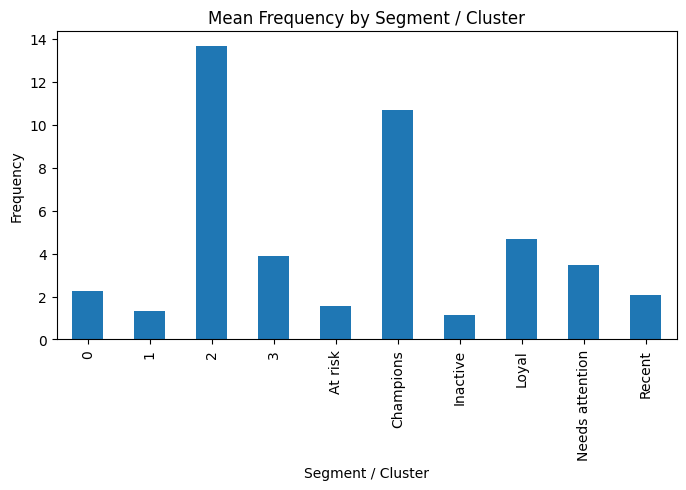

In [48]:
combined_stats[('Frequency', 'mean')].plot(kind='bar', figsize=(8, 4))
plt.title('Mean Frequency by Segment / Cluster')
plt.xlabel('Segment / Cluster')
plt.ylabel('Frequency')
plt.show()

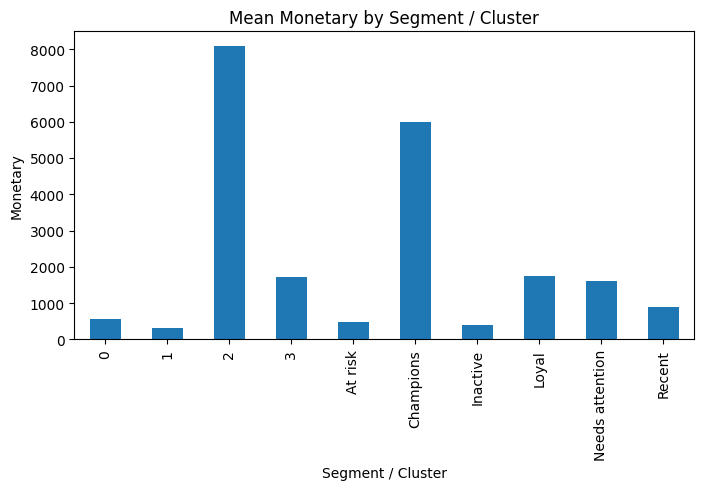

In [49]:
combined_stats[('Monetary', 'mean')].plot(kind='bar', figsize=(8, 4))
plt.title('Mean Monetary by Segment / Cluster')
plt.xlabel('Segment / Cluster')
plt.ylabel('Monetary')
plt.show()

## Mapping of Clusters and RFM Segments

In [50]:
rfm_cl_seg = rfm[['Cluster', 'Segment', 'CustomerID']].groupby(['Cluster', 'Segment']).agg({'count'})
rfm_cl_seg=rfm_cl_seg.reset_index()
rfm_cl_seg.head()

,Cluster,Segment,CustomerID
,,,count
0,0,At risk,80
1,0,Champions,140
2,0,Loyal,340
3,0,Needs attention,45
4,0,Recent,257


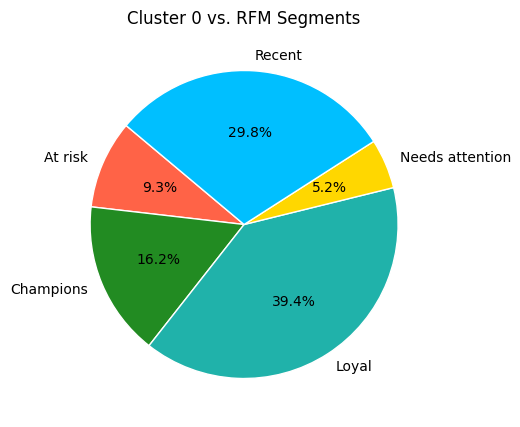

In [51]:
color_mapping = {
    'Champions':'forestgreen',
    'Loyal' : 'lightseagreen',
    'Recent' : 'deepskyblue',
    'Needs attention': 'gold',
    'At risk': 'tomato',
    'Inactive': 'mediumpurple'
    }

rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 0]
plt.figure(figsize=(5, 5))
colors = sns.color_palette('hls')
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 0 vs. RFM Segments')
plt.show()

Cluster 0 contains mainly Loyal and Recent customers. These customers purchased recently however their mean Monetary value was low. This cluster contains 'promising' customers.

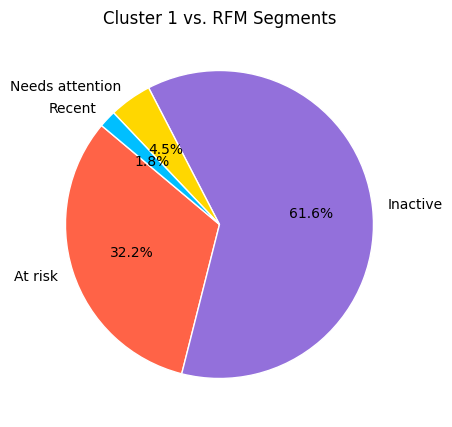

In [52]:
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 1]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 1 vs. RFM Segments')
plt.show()

Cluster 1 has mostly Inactive and At Risk customers as per the RFM Framework.

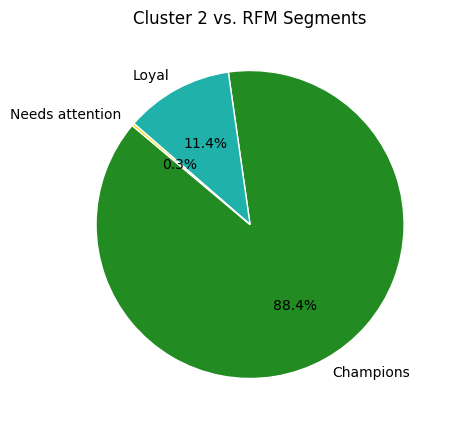

In [53]:
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 2]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 2 vs. RFM Segments')
plt.show()

Cluster 2 almost matches the Segment with Champions. 

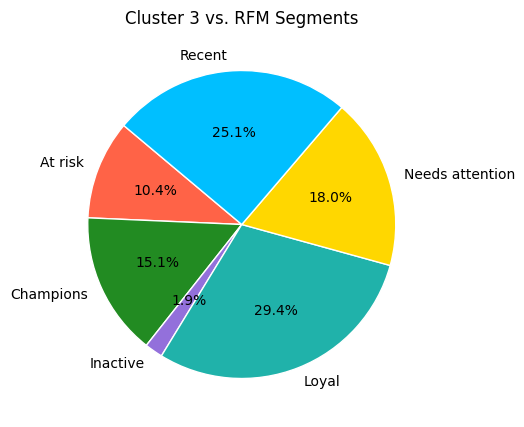

In [54]:
rfm_cluster = rfm_cl_seg[rfm_cl_seg[('Cluster', )] == 3]
plt.figure(figsize=(5, 5))
plt.pie(rfm_cluster[('CustomerID', 'count')], 
        labels=rfm_cluster[('Segment', )], 
        autopct='%1.1f%%', startangle=140, 
        colors=rfm_cluster['Segment'].map(color_mapping), 
        wedgeprops=dict(edgecolor='white'))
plt.title('Cluster 3 vs. RFM Segments')
plt.show()

Cluster 3 has a mix of different RFM segments.

# Conclusion

RFM Segments are easy to interpret and provide recommendations for marketing strategies tailored to each customer segment. However, some segments are not as distinct as those created by K-means clustering.

K-Means clustering generates very distinct segments that may require interpretation.

Interestingly, the Champions segment almost matched in both methods.

 
## Example of marketing strategies for RFM segments
<b> Champions</b>
- Invite them first to sales, promotions, etc.
- Send them rewards or coupons for their loyalty.
- Get reviews from them.

<b> Loyal </b>
- Send them rewards or coupons for their loyalty.
- Use cross-selling or up-selling of similar past purchases or popular products.
- Get reviews from them.
- Invite them to sales, promotions, etc. right after your Champions.
- Encourage or remind them to restock items or past purchases.

<b> Recent </b>
- Convert them to a subscription and try to convert them to Champions
- Offer them a promotion within the average time to order to try to convert them.
- Encourage or remind them to restock items or past purchases.
- Use cross-selling or up-selling of similar past purchases.
- Provide testimonials or reviews from your Champions or Loyal to encourage purchases.

<b> Needs Attention </b>
- Let them know about new product releases.
- Try a winback campaign to re-engage them.
- Offer them an exclusive promotion or coupon (especially time-limited promotions).
- Personalize product recommendations based on what they purchased in the past.
- Encourage or remind them to restock items or past purchases.

<b> At Risk </b>
- Try a winback campaign to re-engage them.
- Offer them an exclusive promotion or coupon (especially time-limited promotions).
- Personalize product recommendations based on what they purchased in the past.
- They may be more price sensitive than the Needs attention group, so target with more affordable products.
- Try not to over-message as they are a churn-risk

<b> Inactive </b>
- Try a winback campaign to re-engage them.
- Offer them an exclusive promotion or coupon (especially time-limited promotions). 


# References

Kaggle notebooks:  
https://www.kaggle.com/code/fabiendaniel/customer-segmentation  
https://www.kaggle.com/code/ozlemilgun/customer-segmentation-using-rfm-analysis   
https://www.kaggle.com/code/fabiendaniel/customer-segmentation  
https://www.kaggle.com/code/sercanyesiloz/crm-analytics  

Article on Investopedia:  
https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

The original article "Optimal Selection for Direct Mail" (1995) that presented the RFM concept:  
https://www.researchgate.net/publication/227442110_Optimal_Selection_for_Direct_Mail

Customer Segmentation Strategies Used on Different Platforms:  
https://www.putler.com/rfm-analysis/   
https://help.klaviyo.com/hc/en-us/articles/17797937793179   
https://help.moengage.com/hc/en-us/articles/360037365132-RFM-Segments   


# Thank you!
Thank you for reading this notebook. Please upvote if you liked the notebook. Your comments and suggestions are highly appreciated. 